In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(style="whitegrid")

In [3]:
np.random.seed(42)

In [4]:
n = 100

In [5]:
X = np.random.normal(loc=0, scale=1, size=n)
noise = np.random.normal(loc=0, scale=1, size=n)

In [6]:
beta_0 = 0
beta_1 = 1
beta_2 = 2
beta_3 = 3

In [7]:
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + noise

In [8]:
df = pd.DataFrame({'Y': Y})
for i in range(1, 11):
    df[f'X{i}'] = X**i

In [9]:
train_df=df.sample(frac=.8, random_state=42)
test_df=df.drop(train_df.index)

In [10]:
def calculate_cp(model, full_model_rss, n, p_full):
    rss = np.sum(model.resid ** 2)
    p = model.df_model + 1  # includes intercept
    cp = (rss / n) + 2 * p * (full_model_rss / n) / n
    return cp

## Forward Stepwise

In [11]:
selected_predictors = []
cp_values = []
models = []

X_full = sm.add_constant(train_df.iloc[:,1:][[f'X{i}' for i in range(1, 11)]])
full_model = sm.OLS(train_df["Y"], X_full).fit()
full_model_rss = np.sum(full_model.resid ** 2)
p_full = full_model.df_model + 1

remaining = [f'X{i}' for i in range(1, 11)]
for k in range(1, 11):
    best_cp = np.inf
    best_model = None
    best_predictor = None

    for predictor in remaining:
        trial_predictors = selected_predictors + [predictor]
        X_trial = sm.add_constant(train_df.iloc[:,1:][trial_predictors])
        model = sm.OLS(train_df["Y"], X_trial).fit()
        cp = calculate_cp(model, full_model_rss, n, p_full)

        if cp < best_cp:
            best_cp = cp
            best_model = model
            best_predictor = predictor

    selected_predictors.append(best_predictor)
    remaining.remove(best_predictor)
    cp_values.append(best_cp)
    models.append(best_model)

In [12]:
best_index = np.argmin(cp_values)
final_model = models[best_index]
final_predictors = selected_predictors[:best_index + 1]

In [13]:
print("Selected predictors:", final_predictors)
print("\nModel coefficients:")
print(final_model.params)

Selected predictors: ['X3', 'X2', 'X1', 'X9']

Model coefficients:
const   -0.145788
X3       3.214666
X2       2.315691
X1       0.645732
X9      -0.005486
dtype: float64


In [14]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     841.5
Date:                Fri, 08 Aug 2025   Prob (F-statistic):           1.85e-61
Time:                        21:35:02   Log-Likelihood:                -103.98
No. Observations:                  80   AIC:                             218.0
Df Residuals:                      75   BIC:                             229.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1458      0.129     -1.131      0.262      -0.403       0.111
X3             3.2147      0.215     14.964      0.000       2.787       3.643
X2             2.3157      0.121     19.101      0.000       2.074       2.557
X1             0.6457      0.304      2.122      0.037       0.040       1.252
X9            -0.0055      0.003     -1.569      0.121      -0.012       0.001
==============================================================================
Omnibus:                        0.168   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.919   Jarque-Bera (JB):                0.340
Skew:                           0.073   Prob(JB):                        0.844
Kurtosis:                       2.716   Cond. No.                         267.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
xcontdf_fs=sm.add_constant(test_df[["X1", "X2", "X3", "X9"]])
pred_fs=final_model.predict(xcontdf_fs)
mse = mean_squared_error(test_df["Y"], pred_fs)
r2 = r2_score(test_df["Y"], pred_fs)
print(f"MSE: {mse}")
print(f"R-Squared: {r2}")

MSE: 270.15063342715797
R-Squared: -0.752319197785621


## Backward Stepwise

In [16]:
predictors = [f'X{i}' for i in range(1, 11)]
X_full = sm.add_constant(train_df[predictors])
full_model = sm.OLS(train_df['Y'], X_full).fit()
full_model_rss = np.sum(full_model.resid ** 2)
p_full = full_model.df_model + 1

In [17]:
current_predictors = predictors.copy()
best_cp = calculate_cp(full_model, full_model_rss, n, p_full)
best_model = full_model

while len(current_predictors) > 1:
    cp_candidates = []
    models = []

    for predictor in current_predictors:
        trial_predictors = [p for p in current_predictors if p != predictor]
        X_trial = sm.add_constant(train_df[trial_predictors])
        model = sm.OLS(train_df['Y'], X_trial).fit()
        cp = calculate_cp(model, full_model_rss, n, p_full)
        cp_candidates.append((cp, predictor, model))

    cp_candidates.sort()
    new_cp, removed, new_model = cp_candidates[0]

    if new_cp < best_cp:
        best_cp = new_cp
        best_model = new_model
        current_predictors.remove(removed)
    else:
        break

In [18]:
print("Selected predictors:", current_predictors)
print("\nModel coefficients:")
print(best_model.params)

Selected predictors: ['X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']

Model coefficients:
const   -0.049289
X3       6.746171
X4       6.833430
X5      -4.840170
X6      -6.320819
X7       2.244570
X8       2.268355
X9      -0.331303
X10     -0.277181
dtype: float64


In [19]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     429.4
Date:                Fri, 08 Aug 2025   Prob (F-statistic):           6.24e-57
Time:                        21:35:03   Log-Likelihood:                -101.03
No. Observations:                  80   AIC:                             220.1
Df Residuals:                      71   BIC:                             241.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0493      0.139     -0.355      0.723      -0.326       0.227
X3             6.7462      1.405      4.800      0.000       3.944       9.548
X4             6.8334      1.404      4.869      0.000       4.035       9.632
X5            -4.8402      2.351     -2.059      0.043      -9.527      -0.153
X6            -6.3208      1.908     -3.313      0.001     -10.125      -2.517
X7             2.2446      1.164      1.928      0.058      -0.077       4.566
X8             2.2684      0.837      2.712      0.008       0.600       3.936
X9            -0.3313      0.175     -1.897      0.062      -0.679       0.017
X10           -0.2772      0.116     -2.386      0.020      -0.509      -0.046
==============================================================================
Omnibus:                        0.059   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.971   Jarque-Bera (JB):                0.038
Skew:                          -0.037   Prob(JB):                        0.981
Kurtosis:                       2.924   Cond. No.                     5.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
xcontdf_bs=sm.add_constant(test_df[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]])
pred_bs=best_model.predict(xcontdf_bs)
mse = mean_squared_error(test_df["Y"], pred_bs)
r2 = r2_score(test_df["Y"], pred_bs)
print(f"MSE: {mse}")
print(f"R-Squared: {r2}")

MSE: 6704.126371805641
R-Squared: -42.48599592998361


In [21]:
lasso_cv = LassoCV(cv=10, random_state=42)

In [22]:
scaler=StandardScaler()
scaled_x=scaler.fit_transform(train_df.iloc[:,1:])
lasso_cv.fit(scaled_x, train_df.iloc[:,0])

,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,10
,verbose,False
,n_jobs,None


In [23]:
alphas = lasso_cv.alphas_
mse_path = lasso_cv.mse_path_.mean(axis=1)
optimal_alpha = lasso_cv.alpha_
coefficients = lasso_cv.coef_

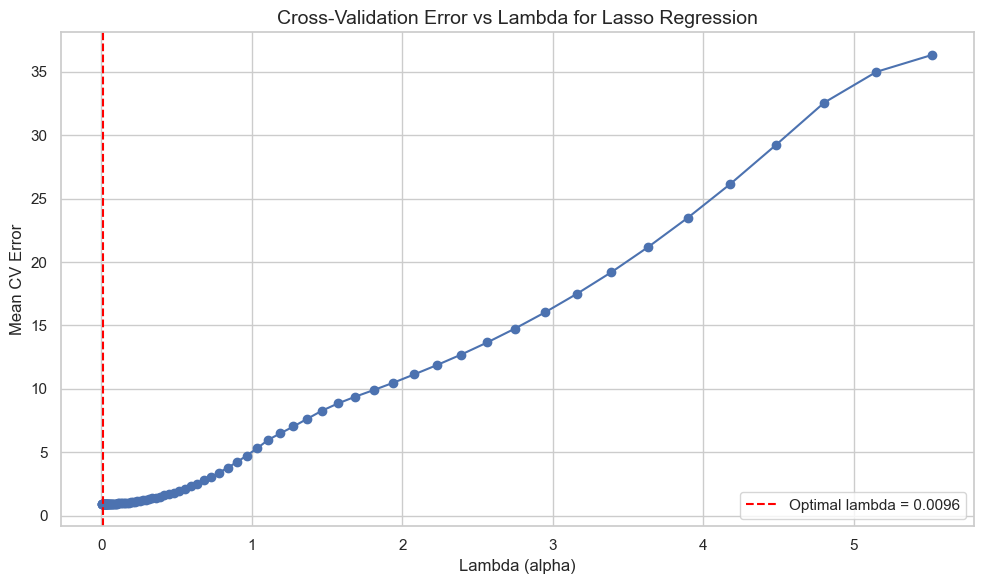

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_path, marker='o')
plt.axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal lambda = {optimal_alpha:.4f}')
plt.xlabel('Lambda (alpha)', fontsize=12)
plt.ylabel('Mean CV Error', fontsize=12)
plt.title('Cross-Validation Error vs Lambda for Lasso Regression', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('lasso_cv_error_plot.png')

In [25]:
print("Optimal lambda (alpha):", optimal_alpha)
print("Lasso Coefficients:")
for i, coef in enumerate(coefficients, start=1):
    print(f"X^{i}: {coef:.4f}")

Optimal lambda (alpha): 0.009649390459009451
Lasso Coefficients:
X^1: 0.5923
X^2: 2.1454
X^3: 5.8530
X^4: -0.0000
X^5: 0.0000
X^6: -0.0000
X^7: -0.0000
X^8: 0.0000
X^9: -0.3069
X^10: 0.0000


In [26]:
scaler=StandardScaler()
scaled_x2=scaler.fit_transform(test_df.iloc[:,1:])

In [27]:
y_pred = lasso_cv.predict(scaled_x2)

In [28]:
mse = mean_squared_error(test_df["Y"], y_pred)
r2 = r2_score(test_df["Y"], y_pred)
non_zero = sum(lasso_cv.coef_ != 0)

print(f"Optimal lambda: {lasso_cv.alpha_}")
print(f"MSE: {mse:.3f}, R²: {r2:.3f}")
print(f"Non-zero coefficients: {non_zero}")

Optimal lambda: 0.009649390459009451
MSE: 66.094, R²: 0.571
Non-zero coefficients: 4


## Forward Stepwise with updated equation (Y=B0 + B7X7 + e)

In [29]:
Y2 = 7 * df['X7'] + noise

In [30]:
df2 = pd.DataFrame({'Y': Y2})
for i in range(1, 11):
    df2[f'X{i}'] = X**i

In [31]:
train_df2=df2.sample(frac=.8, random_state=42)

In [32]:
test_df2=df2.drop(train_df2.index)

In [33]:
selected_predictors = []
cp_values = []
models = []

X_full = sm.add_constant(train_df2[[f'X{i}' for i in range(1, 11)]])
full_model = sm.OLS(train_df2['Y'], X_full).fit()
full_model_rss = np.sum(full_model.resid ** 2)
p_full = full_model.df_model + 1

remaining = [f'X{i}' for i in range(1, 11)]
for k in range(1, 11):
    best_cp = np.inf
    best_model = None
    best_predictor = None

    for predictor in remaining:
        trial_predictors = selected_predictors + [predictor]
        X_trial = sm.add_constant(train_df2[trial_predictors])
        model = sm.OLS(train_df2['Y'], X_trial).fit()
        cp = calculate_cp(model, full_model_rss, n, p_full)

        if cp < best_cp:
            best_cp = cp
            best_model = model
            best_predictor = predictor

    selected_predictors.append(best_predictor)
    remaining.remove(best_predictor)
    cp_values.append(best_cp)
    models.append(best_model)

In [34]:
best_index = np.argmin(cp_values)
final_model = models[best_index]
final_predictors = selected_predictors[:best_index + 1]

In [35]:
print("Selected predictors:", final_predictors)
print("\nModel coefficients:")
print(final_model.params)

Selected predictors: ['X7', 'X2']

Model coefficients:
const   -0.152972
X7       6.989419
X2       0.338266
dtype: float64


In [36]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.930e+05
Date:                Fri, 08 Aug 2025   Prob (F-statistic):          1.43e-170
Time:                        21:35:04   Log-Likelihood:                -104.85
No. Observations:                  80   AIC:                             215.7
Df Residuals:                      77   BIC:                             222.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1530      0.128     -1.194      0.236      -0.408       0.102
X7             6.9894      0.005   1316.197      0.000       6.979       7.000
X2             0.3383      0.118      2.860      0.005       0.103       0.574
==============================================================================
Omnibus:                        0.785   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.675   Jarque-Bera (JB):                0.848
Skew:                           0.101   Prob(JB):                        0.655
Kurtosis:                       2.538   Cond. No.                         31.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
xcontdf2=sm.add_constant(test_df2[["X2", "X7"]])
pred2=final_model.predict(xcontdf2)

In [38]:
mse = mean_squared_error(test_df2["Y"], pred2)
r2 = r2_score(test_df2["Y"], pred2)
print(f"MSE: {mse}")
print(f"R-Squared: {r2}")

MSE: 1654831.532837788
R-Squared: 0.014887421139436752
